# Разделение смеси распределений

EM-алгоритм: sklearn.mixture import GaussianMixture()

Parameters:	
* n_components : int, defaults to 1.
* The covariance_type : {‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
‘full’
each component has its own general covariance matrix

‘tied’
all components share the same general covariance matrix

‘diag’
each component has its own diagonal covariance matrix

‘spherical’
each component has its own single variance

* tol : float, defaults to 1e-3.

* reg_covar : float, defaults to 1e-6.
Non-negative regularization added to the diagonal of covariance. Allows to assure that the covariance matrices are all positive.

* max_iter : int, defaults to 100.

* n_init : int, defaults to 1.
The number of initializations to perform. The best results are kept.

* init_params : {‘kmeans’, ‘random’}, defaults to ‘kmeans’.

* weights_init : array-like, shape (n_components, ), optional
The user-provided initial weights, defaults to None. If it None, weights are initialized using the init_params method.

* means_init : array-like, shape (n_components, n_features), optional
The user-provided initial means, defaults to None, If it None, means are initialized using the init_params method.

* precisions_init : array-like, optional.
The user-provided initial precisions (inverse of the covariance matrices), defaults to None. If it None, precisions are initialized using the ‘init_params’ method. The shape depends on ‘covariance_type’:

* random_state : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
    

## Модельный пример с известными метками

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

X,Y = make_blobs(cluster_std=1.5,random_state=34,n_samples=1000,centers=5)
X = np.dot(X,np.random.RandomState(0).randn(2,2))
x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
XY = np.array([x.flatten(),y.flatten()]).T

model = GaussianMixture(n_components=5).fit(X) 
means = model.means_ 
covariances = model.covariances_

Оцененные компоненты смеси на графике:

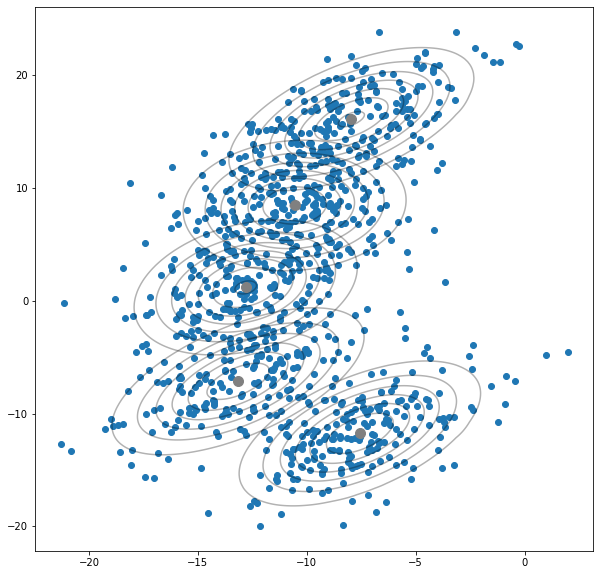

In [2]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    
plt.show()

Предсказанные метки:

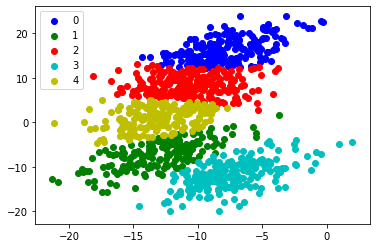

In [3]:
labels = model.predict(X)
import pandas as pd
X = pd.DataFrame(X)
colors = [0, 1, 2, 3, 4]
X['color'] = labels.tolist()
ccolors = ['b', 'g', 'r', 'c' , 'y']
for i in range(0 , len(colors)):
    data = X.loc[X['color'] == colors[i]]
    plt.scatter(data[0], data[1], c=ccolors[i], label=colors[i])
plt.legend()
plt.show()

Истинные:

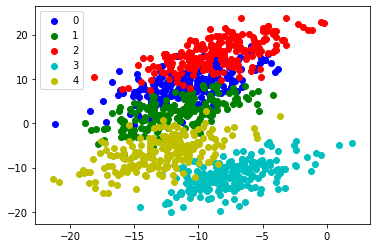

In [4]:
X['color'] = Y
for i in range(0 , len(colors)):
    data = X.loc[X['color'] == colors[i]]
    plt.scatter(data[0], data[1], c=ccolors[i], label=colors[i])
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import classification_report
print(classification_report(Y, labels))

              precision    recall  f1-score   support

           0       0.15      0.14      0.15       200
           1       0.03      0.03      0.03       200
           2       0.16      0.18      0.17       200
           3       0.96      0.97      0.96       200
           4       0.13      0.12      0.13       200

    accuracy                           0.29      1000
   macro avg       0.28      0.29      0.29      1000
weighted avg       0.28      0.29      0.29      1000



Графики и значения метрик наводят на мысль, что кластера перенумеровались (нумерация в предсказанных не совпадает с нумерацией в исходных метках).

In [11]:
labelscopy = labels
for i in range(0, len(Y)-1):
    if labelscopy[i] == 0: labelscopy[i] = 2
    if labelscopy[i] == 2: labelscopy[i] = 0
    if labelscopy[i] == 4: labelscopy[i] = 1
    if labelscopy[i] == 1: labelscopy[i] = 4

from sklearn.metrics import classification_report
print(classification_report(Y, labelscopy))

              precision    recall  f1-score   support

           0       0.41      0.87      0.56       200
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00       200
           3       0.96      0.97      0.96       200
           4       0.51      0.95      0.66       200

    accuracy                           0.56      1000
   macro avg       0.38      0.56      0.44      1000
weighted avg       0.38      0.56      0.44      1000



Метрики кач--ва кластеризации:
* внешние (используют информацию об истинном разбиении на кластеры)
* внутренние (оценивают качество кластеризации, основываясь только на наборе данных)

#### Adjusted Rand Index (ARI)
Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть  — число объектов в выборке. Обозначим через  — число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через  — число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда Rand Index это

$$RI = \frac{2(a+b)}{n(n-1)}, $$

т.о. это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом  и числе кластеров, необходимо нормировать его:

$$ARI = \frac{RI - \mathbf{E}RI}{\max(RI) -\mathbf{E}RI}$$

#### Гомогенность, полнота, V-мера

Определяются с использованием функций энтропии и условной энтропии (выборки рассматриваются как дискретные распределения):

$$h = 1 - \frac{H(C|K)}{H(C)}, c = 1 - \frac{H(K|C)}{H(K)}, \text{где}$$


$K$ --- результат кластеризации,  $C$ --- истинное разбиение выборки на классы. Таким образом, $h$ измеряет, насколько каждый кластер состоит из объектов одного класса, а  $c$ --- насколько объекты одного класса относятся к одному кластеру. Эти меры не нормализованы $\Rightarrow$ зависят от числа кластеров.

$V$--мера опредляется как среднее гармоническое $h$ и $c$: $$v = 2\frac{hc}{h+c},$$ и показывает, насколько две кластеризации схожи между собой.

#### Силуэт

Не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Обозначим через $a$ — среднее расстояние от данного объекта до объектов из того же кластера, через $b$ — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина $$s = \frac{a-b}{\max(a,b)}.$$
Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров (чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек) 

In [15]:
from sklearn import metrics

print("ARI: %0.3f"
      % metrics.adjusted_rand_score(Y, labelscopy))
print("Homogenity: %0.3f"
      % metrics.homogeneity_score(Y, labelscopy))
print("Completeness: %0.3f"
      % metrics.completeness_score(Y, labelscopy))
print("V-measure: %0.3f"
      % metrics.v_measure_score(Y, labelscopy))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[[0,1]], labelscopy))

ARI: 0.473
Homogenity: 0.501
Completeness: 0.759
V-measure: 0.604
Silhouette Coefficient: 0.256


## Пример с подбором числа кластеров

In [43]:
import pandas as pd

data = pd.read_csv('untitled.txt', sep="	", header=None)
data.columns = ["x", "y", "label"]
X_2 = data[["x", "y"]]
print(data['label'].unique())

[2 7 4 3 6 1 5]


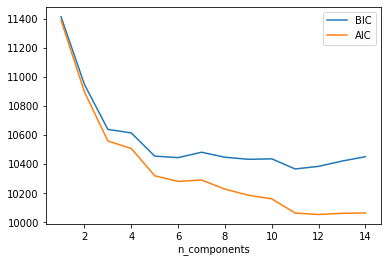

In [44]:
n_components = np.arange(1, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_2)
          for n in n_components]

plt.plot(n_components, [m.bic(X_2) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_2) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

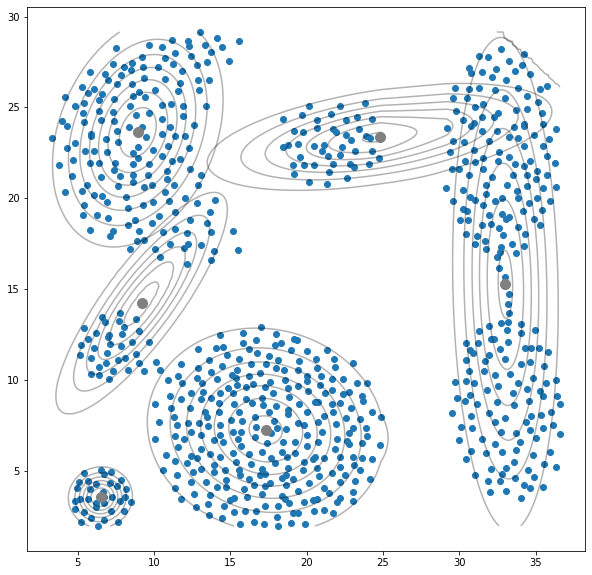

In [45]:
model = GaussianMixture(n_components=6).fit(X_2) 
means = model.means_ 
covariances = model.covariances_
x,y = np.meshgrid(np.sort(X_2["x"]),np.sort(X_2["y"]))
XY = np.array([x.flatten(),y.flatten()]).T

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X_2["x"],X_2["y"])
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(np.sort(X_2["x"]),np.sort(X_2["y"]),multi_normal.pdf(XY).reshape(len(X_2),len(X_2)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    
plt.show()

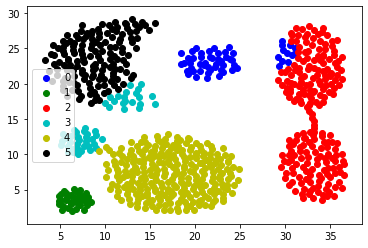

In [46]:
labels = model.predict(X_2)
X_2 = pd.DataFrame(X_2)
colors = [0, 1, 2, 3, 4, 5]
X_2['color'] = labels.tolist()
ccolors = ['b', 'g', 'r', 'c' , 'y', 'k']
for i in range(0 , len(colors)):
    data2 = X_2.loc[X_2['color'] == colors[i]]
    plt.scatter(data2['x'], data2['y'], c=ccolors[i], label=colors[i])
plt.legend()
plt.show()

In [49]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_2[['x','y']], labels))

Silhouette Coefficient: 0.397


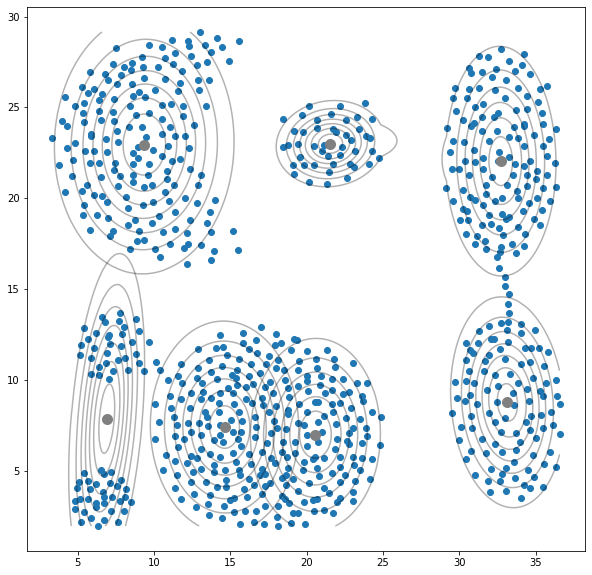

In [50]:
X_2 = data[["x", "y"]]

model = GaussianMixture(n_components=7).fit(X_2) 
means = model.means_ 
covariances = model.covariances_
x,y = np.meshgrid(np.sort(X_2["x"]),np.sort(X_2["y"]))
XY = np.array([x.flatten(),y.flatten()]).T

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X_2["x"],X_2["y"])
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(np.sort(X_2["x"]),np.sort(X_2["y"]),multi_normal.pdf(XY).reshape(len(X_2),len(X_2)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    
plt.show()

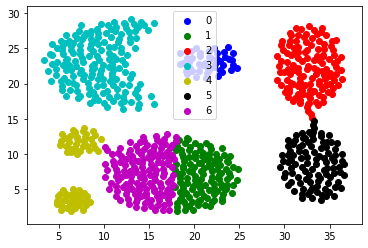

In [51]:
labels = model.predict(X_2)
X_2 = pd.DataFrame(X_2)
colors = [0, 1, 2, 3, 4, 5, 6]
X_2['color'] = labels.tolist()
ccolors = ['b', 'g', 'r', 'c' , 'y', 'k', 'm']
for i in range(0 , len(colors)):
    data2 = X_2.loc[X_2['color'] == colors[i]]
    plt.scatter(data2['x'], data2['y'], c=ccolors[i], label=colors[i])
plt.legend()
plt.show()

In [52]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_2[['x','y']], labels))

Silhouette Coefficient: 0.484


# Кластеризация

## K-means

Parameters:
    
* n_clusters : int, optional, default: 8

* init : {‘k-means++’, ‘random’ or an ndarray}
Method for initialization, defaults to ‘k-means++’:

* n_init : int, default: 10
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

* max_iter : int, default: 300

* tol : float, default: 1e-4
Relative tolerance with regards to inertia to declare convergence

* precompute_distances : {‘auto’, True, False}

* random_state : int, RandomState instance or None (default)

* n_jobs : int or None, optional (default=None)

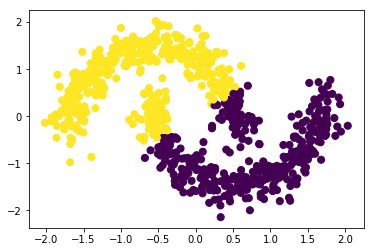

In [71]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=750, shuffle=True, noise=0.11, random_state=42)
X = StandardScaler().fit_transform(X)

from sklearn.cluster import KMeans

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In [72]:
print("ARI: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Homogenity: %0.3f"
      % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f"
      % metrics.completeness_score(y, labels))
print("V-measure: %0.3f"
      % metrics.v_measure_score(y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

ARI: 0.458
Homogenity: 0.363
Completeness: 0.363
V-measure: 0.363
Silhouette Coefficient: 0.485


## DBSCAN

Parameters:
    
* eps : float, optional

The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

* min_samples : int, optional

The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

* metric : string, or callable

The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by sklearn.metrics.pairwise_distances for its metric parameter. If metric is “precomputed”, X is assumed to be a distance matrix and must be square. X may be a sparse matrix, in which case only “nonzero” elements may be considered neighbors for DBSCAN.

* algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional

The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. See NearestNeighbors module documentation for details.

* n_jobs : int or None, optional (default=None)

The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

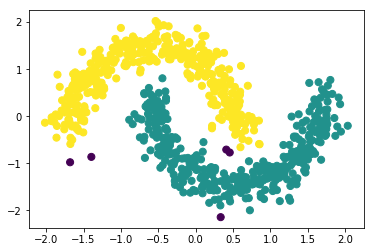

In [73]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=750, shuffle=True, noise=0.11, random_state=42)
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In [74]:
print("ARI: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Homogenity: %0.3f"
      % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f"
      % metrics.completeness_score(y, labels))
print("V-measure: %0.3f"
      % metrics.v_measure_score(y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

ARI: 0.987
Homogenity: 0.995
Completeness: 0.947
V-measure: 0.970
Silhouette Coefficient: 0.225


# Иерархическая кластеризация

AgglomerativeClustering in sklearn

* n_clusters : int or None, optional (default=2)

* affinity : string or callable, default: “euclidean”

Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted. If “precomputed”, a distance matrix (instead of a similarity matrix) is needed as input for the fit method.

* connectivity : array-like or callable, optional

* compute_full_tree : bool or ‘auto’ (optional)

* linkage : {“ward”, “complete”, “average”, “single”}, optional (default=”ward”)

In [88]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [89]:
df.drop("CustomerID", axis = 1, inplace = True)
df = pd.get_dummies(df, columns=["Genre"])
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Genre_Female,Genre_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


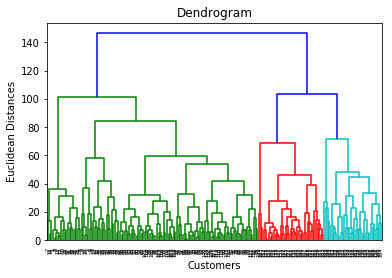

In [102]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show() 

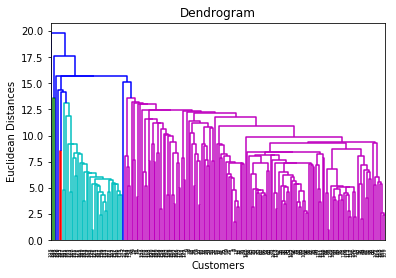

In [101]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show() 

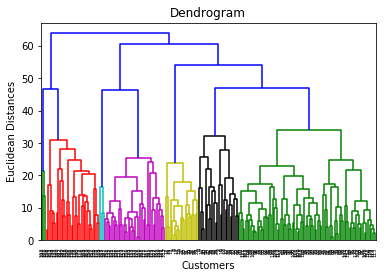

In [100]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df, method = 'average'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show() 

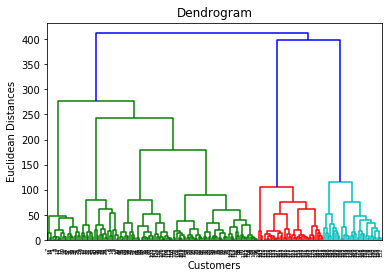

In [97]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show() 

No handles with labels found to put in legend.


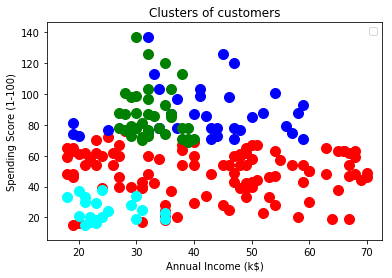

In [107]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_pred = model.fit_predict(X)

plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red')
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue')
plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green')
plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan')

plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [108]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, y_pred))

Silhouette Coefficient: 0.410


No handles with labels found to put in legend.


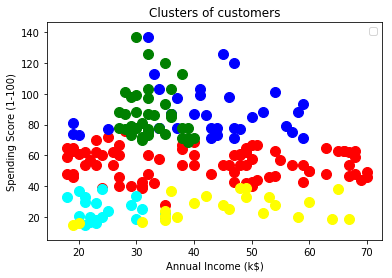

In [109]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
model = model.fit_predict(X)

plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red')
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue')
plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green')
plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan')
plt.scatter(X[y_pred == 4, 0], X[y_pred == 4, 1], s = 100, c = 'yellow')

plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [110]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, y_pred))

Silhouette Coefficient: 0.440


# Еще немного про метрики

Algo:  MiniBatchKMeans , Dataset:  0
Silhouette Coefficient: 0.349
Algo:  Ward , Dataset:  0
Silhouette Coefficient: 0.268
Algo:  AgglomerativeClustering , Dataset:  0
Silhouette Coefficient: 0.114
Algo:  DBSCAN , Dataset:  0
Silhouette Coefficient: 0.114
Algo:  GaussianMixture , Dataset:  0
Silhouette Coefficient: 0.351
Algo:  MiniBatchKMeans , Dataset:  1
Silhouette Coefficient: 0.500
Algo:  Ward , Dataset:  1
Silhouette Coefficient: 0.389
Algo:  AgglomerativeClustering , Dataset:  1
Silhouette Coefficient: 0.389
Algo:  DBSCAN , Dataset:  1
Silhouette Coefficient: 0.389
Algo:  GaussianMixture , Dataset:  1
Silhouette Coefficient: 0.500
Algo:  MiniBatchKMeans , Dataset:  2
Silhouette Coefficient: 0.625
Algo:  Ward , Dataset:  2
Silhouette Coefficient: 0.613
Algo:  AgglomerativeClustering , Dataset:  2
Silhouette Coefficient: 0.615
Algo:  DBSCAN , Dataset:  2
Silhouette Coefficient: 0.532
Algo:  GaussianMixture , Dataset:  2
Silhouette Coefficient: 0.596


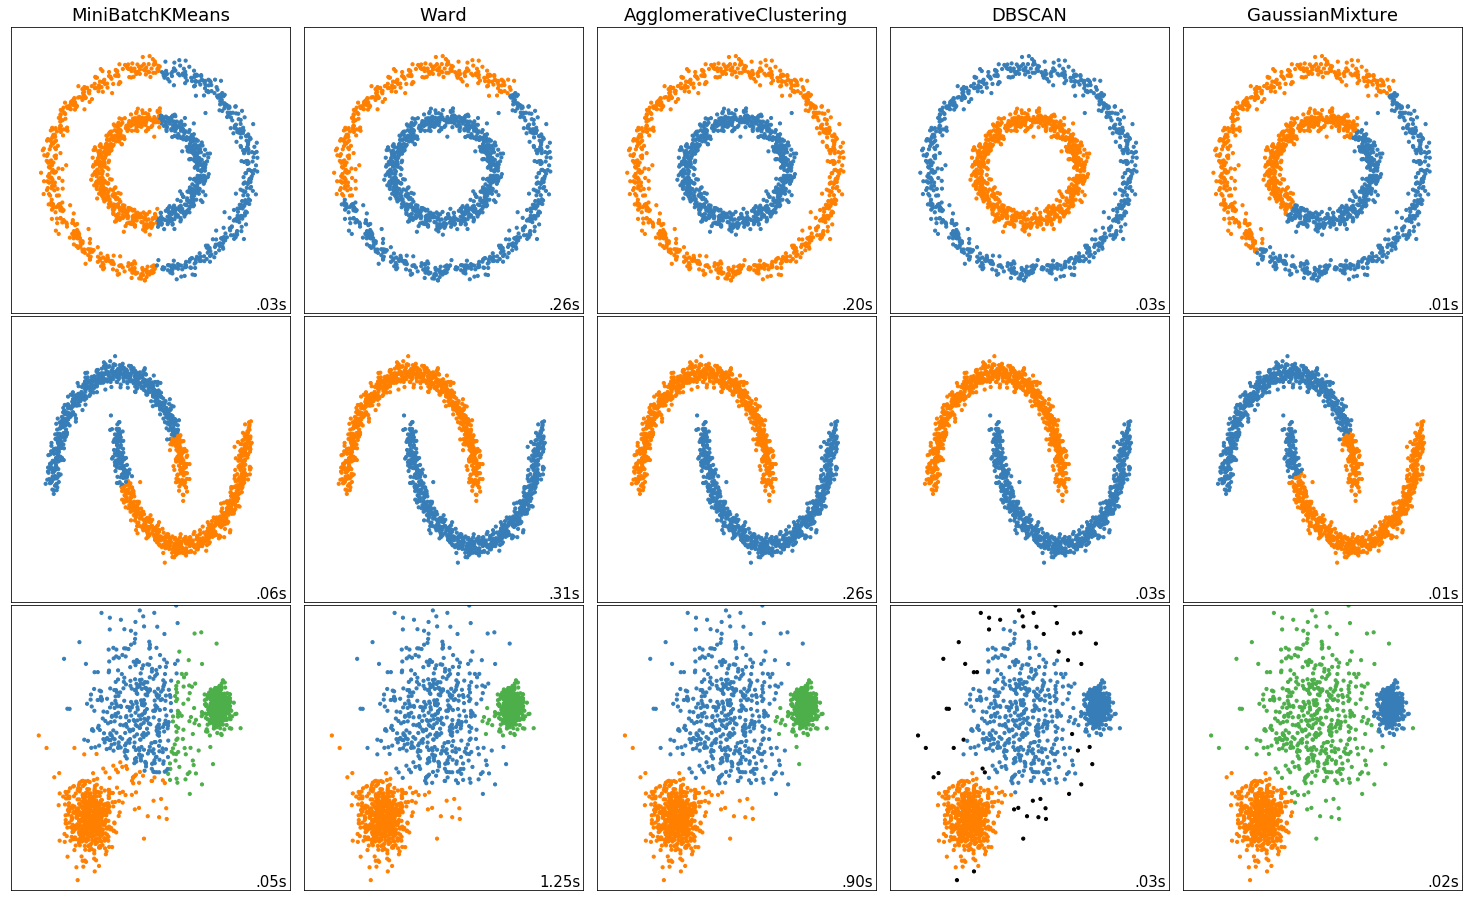

In [62]:
%matplotlib inline
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)
    X, y = dataset
    X = StandardScaler().fit_transform(X)


    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    dbscan = cluster.DBSCAN(eps=params['eps'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        
        print("Algo: ", name, ", Dataset: ", i_dataset)
        print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, y_pred))
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()